# Data Analysis Spark

Date: 04/09/2019

Libraries used:

* malplotlib.pyplot (for creating plots)
* pyspark (for using sparkCore)
* pyspark.sql (for utilising sparkSQL)
* datetime (for converting string into dates)
* pyspark.sql.types (for datatype for UDF)
* pyspark.sql.functions (to create the UDFs)
* csv (to read the csv file)
* os (to use mongodb)

## 1. Introduction
This task of the notebook consist of using the power of spark dataframes to analyse the `.csv` file

More details for each task will be given in the following sections.

## Step 1

We start by importing the libraries and initialising the Spark

In [1]:

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.types import DateType,IntegerType
from pyspark.sql.functions import udf
from io import StringIO
import matplotlib.pyplot as plt
from pyspark.sql import functions as sf
import csv
import os

In [2]:

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

sc = SparkContext.getOrCreate()

if (sc == None):
    sc = SparkContext(master = "local[*]")

spark = SparkSession(sparkContext = sc)\
        .builder\
        .appName("Assignment 1B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/assign_1.criminal_rec")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/assign_1.criminal_rec")\
        .getOrCreate()

## Step 2
Creating a dataframe from the `.CSV` file and checking for empty rows. If a row is empty we romove the row.

In [3]:
df = spark.read.option("header", "true").csv("data/Crime_Statistics_SA_2010_present.csv")


In [4]:
df.filter(df["Reported Date"].isNull()).count()

1

In [5]:
df.filter(df["Reported Date"].isNull()).show()

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|         null|             null|               null|                       null|                       null|                       null|         null|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+



After removing the null row we print the number of rows left in the CSV file

In [6]:
df = df.filter(df["Reported Date"].isNotNull())
print("Total Number of Records :", df.count())

Total Number of Records : 727407


## Step 3

We write the content of the dataframe into the mongoDB database and then load it again in the `criminal_df` dataframe

In [7]:
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## Step 4

We read the database and create a dataframe from it. Finally, we print the schema of the dataframe.

In [8]:
criminal_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [9]:
criminal_df.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 5

We calculate the statistic for Reported Date and Offense Count

In [10]:
std_rep = criminal_df.agg({"Reported Date": "std"}).collect()[0][0]
min_rep = criminal_df.agg({"Reported Date": "min"}).collect()[0][0]
max_rep = criminal_df.agg({"Reported Date": "max"}).collect()[0][0]
count_rep = criminal_df.agg({"Reported Date": "count"}).collect()[0][0]
mean_rep = criminal_df.agg({"Reported Date": "mean"}).collect()[0][0]

print("The Min value for Reported Date is :",min_rep)
print("The Max value for Reported Date is :",max_rep)
print("The Count value for Reported Date is :",count_rep)
print("The STD value for Reported Date is :",std_rep)
print("The Mean value for Reported Date is :",mean_rep)

The Min value for Reported Date is : 1/01/2011
The Max value for Reported Date is : 9/12/2018
The Count value for Reported Date is : 727407
The STD value for Reported Date is : None
The Mean value for Reported Date is : None


- Here we use the aggregate function to get the statistic. It is really important for us to note that the statistics provided except the count value is **wrong**. The reason being the dates are stored as string so the min and max value for date is based on string comparison. Also, since dates can not be converted into numbers, their standard deviation and mean does not makes sense and hence is not calculated by the function. 

In [11]:
std_off = criminal_df.agg({"Offence Count": "std"}).collect()[0][0]
min_off = criminal_df.agg({"Offence Count": "min"}).collect()[0][0]
max_off = criminal_df.agg({"Offence Count": "max"}).collect()[0][0]
count_off = criminal_df.agg({"Offence Count": "count"}).collect()[0][0]
mean_off = criminal_df.agg({"Offence Count": "mean"}).collect()[0][0]


print("The Min value for Offence Count is :",min_off)
print("The Max value for Offence Count is :",max_off)
print("The Count value for Offence Count is :",count_off)
print("The STD value for Offence Count is :",std_off)
print("The Mean value for Offence Count is :",mean_off)

The Min value for Offence Count is : 1
The Max value for Offence Count is : 9
The Count value for Offence Count is : 727407
The STD value for Offence Count is : 0.5787050930378095
The Mean value for Offence Count is : 1.1715174585892079


- Here we use the aggregate function to get the statistic for offence. As was the case with dates it is important for us to note that the statistics provided for max value and min value are **wrong**, the reason being that they are stored as strings so the min and max values are based on string comparison. 

Since offence count are numbers, they are converted by the inbuilt functions into numbers and then the stats are calculated giving **correct** information about mean and std.

## Step 6
We use UDFs to convert string into dates for reported dates column

In [12]:
def convert_date(date):
    return datetime.strptime(date,'%d/%m/%Y')

In [13]:
date_udf = udf(lambda x: convert_date(x), DateType())

In [14]:
criminal_df = criminal_df.withColumn('Reported Date',date_udf('Reported Date'))


## Step 7

We do data snalysis in this step
- We start by calculating the number of level 2 offences

In [15]:
distinct_2_offence = criminal_df.select("Offence Level 2 Description").distinct()
distinct_2_offence.show()

+---------------------------+
|Offence Level 2 Description|
+---------------------------+
|       ROBBERY AND RELAT...|
|       PROPERTY DAMAGE A...|
|       SEXUAL ASSAULT AN...|
|       HOMICIDE AND RELA...|
|       ACTS INTENDED TO ...|
|       SERIOUS CRIMINAL ...|
|       OTHER OFFENCES AG...|
|       FRAUD DECEPTION A...|
|       THEFT AND RELATED...|
+---------------------------+



In [16]:
print("Number of Level 2 offences :",distinct_2_offence.count())

Number of Level 2 offences : 9


We convert offence count to integer for data analysis using the UDFs

In [17]:
def convert_offence_count(count):
    return int(count)
offence_udf = udf(lambda x: convert_offence_count(x), IntegerType())
criminal_df = criminal_df.withColumn('Offence Count',offence_udf('Offence Count'))


- We calculate the number of offences against the persons

In [18]:
off_prsn = criminal_df.filter(criminal_df["Offence Level 1 Description"] == "OFFENCES AGAINST THE PERSON").agg({"Offence Count":"sum"})
print("The number of offences against the persons is :",off_prsn.collect()[0][0])


The number of offences against the persons is : 175644


- Calculating number of serious criminal tresspasses with more than 1 offence count 

In [19]:
serious_crim_tress = criminal_df.filter(criminal_df["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS").filter(criminal_df["Offence Count"] >1).count()
print("The number of serious criminal tresspasses with more than 1 offence count is :",serious_crim_tress)



The number of serious criminal tresspasses with more than 1 offence count is : 8579


- calculating the percentage of crimes that are offences against property 

In [20]:

off_pprty = criminal_df.filter(criminal_df["Offence Level 1 Description"] == "OFFENCES AGAINST PROPERTY").agg({"Offence Count":"sum"})
total = criminal_df.agg({"Offence Count":"sum"})
percent = (off_pprty.collect()[0]["sum(Offence Count)"]/total.collect()[0]["sum(Offence Count)"])*100


In [21]:
print("The percentage of crimes that are offences against property is :",percent)


The percentage of crimes that are offences against property is : 79.3886196416208


Now we manipulate the data, add a few colummns that can help us with `exploratory data analysis`

In [22]:
def get_year(date):
    return date.year

In [23]:
def get_month(date):
    return date.month

In [24]:
def get_day(date):
    return date.day

In [25]:
year_udf = udf(lambda x: get_year(x), IntegerType())
month_udf = udf(lambda x: get_month(x), IntegerType())
day_udf = udf(lambda x: get_day(x), IntegerType())

In [26]:
crime_time = criminal_df.withColumn('Year',year_udf('Reported Date'))
crime_time = crime_time.withColumn('Month',month_udf('Reported Date'))
crime_time = crime_time.withColumn('Day',day_udf('Reported Date'))

## Step 8
We start by plotting the number of crimes per year

In [27]:
yearwise_crime = crime_time.select("Year","Offence Count").groupBy("Year").sum("Offence Count").sort("Year").collect()

In [28]:
x_lab = [each_row["Year"] for each_row in yearwise_crime]
y_lab = [each_row["sum(Offence Count)"] for each_row in yearwise_crime]

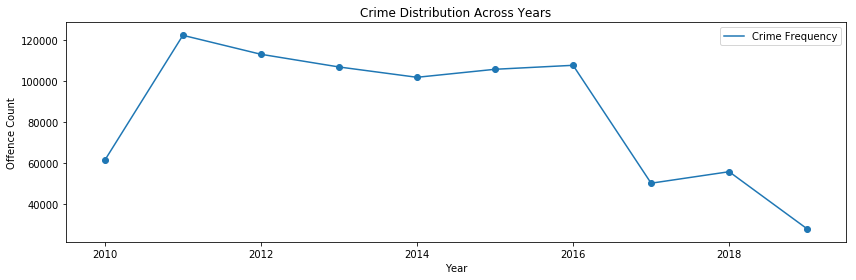

In [29]:
fig,ax = plt.subplots(figsize = (12,4))
ax.plot(x_lab,y_lab,label = "Crime Frequency")
ax.scatter(x_lab,y_lab)
ax.legend(loc = 'upper right')
ax.set_xlabel('Year')
ax.set_ylabel('Offence Count')
ax.set_title("Crime Distribution Across Years")
plt.tight_layout()
plt.show()

- From the graph above we can observe that the number of crimes shooted high between 2010 adn 2011 and then consistently dropped for the next 8 years with only a few minor setback in the year 2015 and 2018 where the number of offences grew just by a minor amount as compared to the year preceding it. 

In [30]:
monthwise_crime = crime_time.select("Month","Offence Count").groupBy("Month").sum("Offence Count").sort("Month").collect()
x_lab = [each_row["Month"] for each_row in monthwise_crime]
y_lab = [each_row["sum(Offence Count)"] for each_row in monthwise_crime]



Number of crimes per month

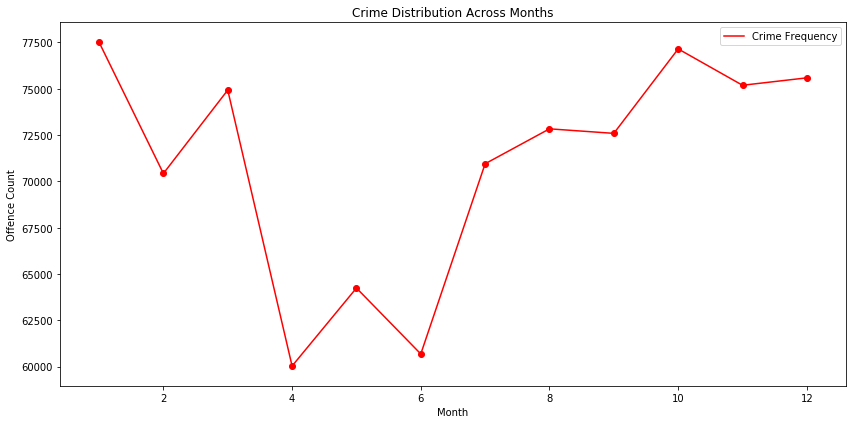

In [31]:
fig,ax = plt.subplots(figsize = (12,6))
ax.plot(x_lab,y_lab,label = "Crime Frequency",color='r')
ax.scatter(x_lab,y_lab,color='r')
ax.legend(loc = 'upper right')
ax.set_xlabel('Month')
ax.set_ylabel('Offence Count')
ax.set_title("Crime Distribution Across Months")
plt.tight_layout()
plt.show()

- From the graph above we can observe that the crime rate was high during the begining and the end of the year and was low during the middle of the year. This is evident by the inverse bell like shape of the plot

Most crime places:
For plotting the data it is very important to know the places and their postcodes. So before we plot the graph, we remove the rows for which both of them are missing.

In [32]:
criminal_df_new = criminal_df.filter(((criminal_df["Postcode - Incident"].isNotNull()) & (criminal_df["Suburb - Incident"].isNotNull())))
criminal_df_new = criminal_df_new.filter(((criminal_df_new["Postcode - Incident"] != "NOT DISCLOSED") & (criminal_df_new["Suburb - Incident"] != "NOT DISCLOSED")))


In [33]:
suburb_offence = criminal_df_new.select("Postcode - Incident","Suburb - Incident","Offence Count").groupBy("Suburb - Incident","Postcode - Incident").sum("Offence Count").sort("sum(Offence Count)",ascending = False)
sub_crime_df = suburb_offence.withColumn('Label',sf.concat(sf.col('Suburb - Incident'),sf.lit(' - '), sf.col('Postcode - Incident'))).limit(20).collect()


In [34]:
sub_labels = [each_row["Label"] for each_row in sub_crime_df]
sub_offence = [each_row["sum(Offence Count)"] for each_row in sub_crime_df]

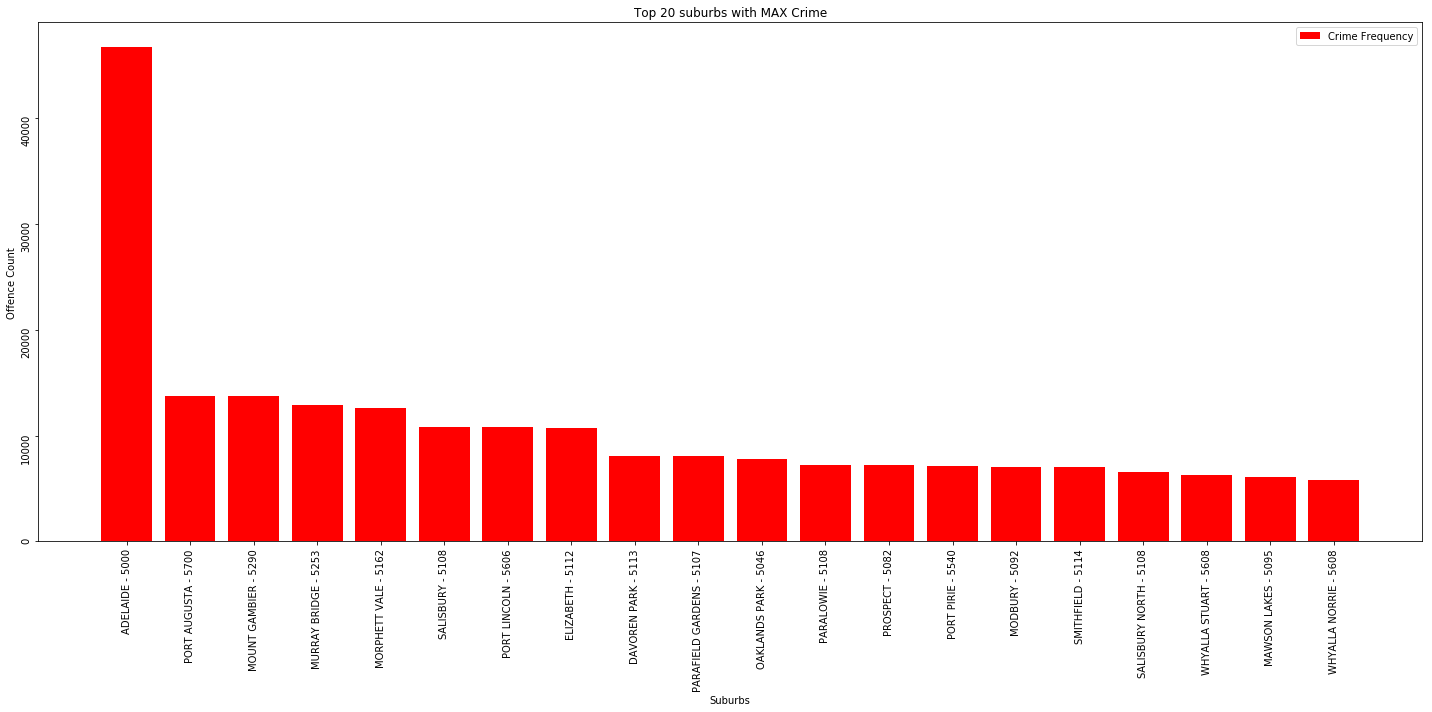

In [35]:
fig,ax = plt.subplots(figsize = (20,10))
ax.bar(sub_labels,sub_offence,label = "Crime Frequency",color='r')
ax.legend(loc = 'upper right')
ax.set_xlabel('Suburbs')
ax.set_ylabel('Offence Count')
ax.set_title("Top 20 suburbs with MAX Crime")
ax.tick_params(labelrotation=90)
plt.tight_layout()
plt.show()

From the graph above we can see that Adelaide has most number of crime occuring over the time frame. Not only is it maximum for Adelaide but also is inconsistent witht the number of offences in other suburbs as the offence count is greater than double the count of the following suburb

Also it is evident from the graph that the number of offences over time for rest of the suburbs is almost same.

In [36]:
crime_by_day = crime_time.filter(crime_time["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS").groupBy("Day").sum("Offence Count").sort("Day").collect()

crime_by_month = crime_time.filter(crime_time["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS").groupBy("Month").sum("Offence Count").sort("Month").collect()


Number of serious criminal Trespasses by day and month

In [37]:
x_day = [each_row["Day"] for each_row in crime_by_day]
y_day = [each_row["sum(Offence Count)"] for each_row in crime_by_day]

x_month = [each_row["Month"] for each_row in crime_by_month]
y_month = [each_row["sum(Offence Count)"] for each_row in crime_by_month]

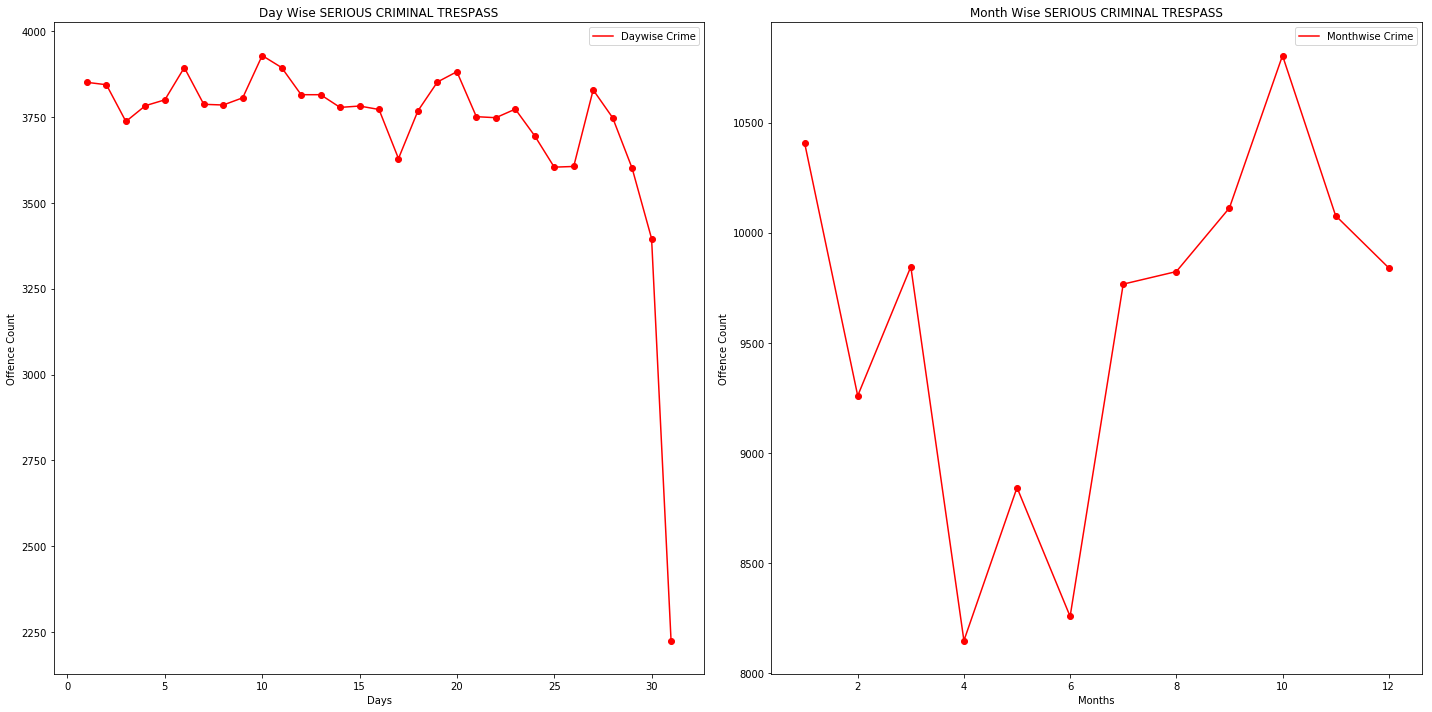

In [38]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.plot(x_day,y_day,label = "Daywise Crime",color='r')
ax1.scatter(x_day,y_day,color='r')
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Days')
ax1.set_ylabel('Offence Count')
ax1.set_title("Day Wise SERIOUS CRIMINAL TRESPASS")

ax2.plot(x_month,y_month,label = "Monthwise Crime",color='r')
ax2.scatter(x_month,y_month,color='r')
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Months')
ax2.set_ylabel('Offence Count')
ax2.set_title("Month Wise SERIOUS CRIMINAL TRESPASS")

plt.tight_layout()
plt.show()

- We can observe from the graph above on the left that the number of serious criminal tresspasses stay almost same throughout the month except for last few days. The variation in number for the majority of the day is very less implying there is no correlation or very less correlation between the day and number of offences

- Secondly from the graph on the right we can see a clear relation between the monthn and offence, i.e. most of the offence occure during either the begining or the end of the year and the number of serious criminal tresspass drops in the middle of the year